In [9]:
import os
import json
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from tqdm.notebook import tqdm
import timm
import ee
import geemap
import requests
from io import BytesIO

# --- CONFIGURATION CHANGES HERE ---
# 1. Update this to your potato shapefile path
NEW_DATA_PATH = Path('potato/Classes_PDT2021.shp') 

# 2. Save potato tiles to a new folder so they don't mix with cereal
OUTPUT_DIR = Path('output/potato_inference_data')

# 3. Path to the model (If you have a specific potato model, change this filename)
MODEL_PATH = Path('output/swin_cereal_classifier.pth') 

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Inference target: POTATOES")

Using device: cuda
Inference target: POTATOES


In [10]:
try:
    ee.Initialize(project='mythical-sweep-471412-h5')
    print("Google Earth Engine initialized successfully!")
except Exception as e:
    print("Authenticating...")
    ee.Authenticate()
    ee.Initialize(project='mythical-sweep-471412-h5')
    print("Authenticated and initialized.")

Google Earth Engine initialized successfully!


In [12]:
import geopandas as gpd
from shapely.geometry import Point, box
import math

# Function to generate grid points for a large geometry
def generate_tile_centers(geometry, patch_size_m=1280, stride_m=1280):
    """
    Splits a geometry into a grid of 1280m x 1280m tiles.
    Returns a list of center points (Lat/Lon) for each tile.
    """
    # 1. Create a temporary GeoSeries to handle projection
    gs = gpd.GeoSeries([geometry], crs="EPSG:4326")
    
    # 2. Reproject to a metric CRS (UTM) to measure in meters
    # Estimate the best UTM zone automatically
    crs_metric = gs.estimate_utm_crs()
    gs_metric = gs.to_crs(crs_metric)
    geom_metric = gs_metric.iloc[0]
    
    # 3. Get Bounding Box
    minx, miny, maxx, maxy = geom_metric.bounds
    
    # 4. Generate Grid Centers
    centers = []
    half_patch = patch_size_m / 2
    
    # Iterate x and y
    current_x = minx + half_patch
    while current_x < (maxx + half_patch): # Ensure we cover the edge
        current_y = miny + half_patch
        while current_y < (maxy + half_patch):
            # Create a candidate tile center
            center_point = Point(current_x, current_y)
            
            # Create the square tile footprint (for intersection check)
            # cap_style=3 creates a square buffer (bounding box)
            tile_poly = center_point.buffer(half_patch, cap_style=3)
            
            # Only keep this tile if it actually touches the user's polygon
            if tile_poly.intersects(geom_metric):
                centers.append(center_point)
            
            current_y += stride_m
        current_x += stride_m
        
    # 5. Convert centers back to Lat/Lon (WGS84)
    if not centers:
        return []
        
    centers_gs = gpd.GeoSeries(centers, crs=crs_metric).to_crs("EPSG:4326")
    return centers_gs.tolist()

# Function to download one specific patch
def download_single_tile(center_point, tile_id, output_dir):
    # Time range
    start_date = '2023-01-01'
    end_date = '2023-04-30'
    bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
    
    # Define ROI: 1280m box around the center point
    # We buffer by 640m radius => 1280m width
    roi = ee.Geometry.Point([center_point.x, center_point.y]).buffer(640).bounds()
    
    s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterBounds(roi) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    
    def mask_clouds(image):
        scl = image.select('SCL')
        mask = scl.eq(4).Or(scl.eq(5)).Or(scl.eq(6))
        return image.updateMask(mask)

    composite = s2.map(mask_clouds).select(bands).median()
    
    try:
        url = composite.getDownloadURL({
            'name': f'patch_{tile_id}',
            'bands': bands,
            'region': roi,
            'scale': 10,
            'format': 'NPY'
        })
        
        response = requests.get(url)
        data = np.load(BytesIO(response.content))
        
        if data.dtype.names:
            arr_list = [data[b].astype(np.float32) for b in bands]
            final_arr = np.stack(arr_list, axis=0)
        else:
            final_arr = data
            
        # Crop to exact 128x128
        _, h, w = final_arr.shape
        start_h = (h - 128) // 2
        start_w = (w - 128) // 2
        
        if start_h >= 0 and start_w >= 0:
            final_arr = final_arr[:, start_h:start_h+128, start_w:start_w+128]
            np.save(output_dir / f"S2_{tile_id}.npy", final_arr)
            return True
        return False
        
    except Exception as e:
        print(f"Error on {tile_id}: {e}")
        return False


# --- Main Execution ---
print(f"Loading Potato shapefile: {NEW_DATA_PATH}")

# Load the potato shapefile
try:
    gdf = gpd.read_file(NEW_DATA_PATH)
    if gdf.crs != 'EPSG:4326':
        gdf = gdf.to_crs('EPSG:4326')
    print(f"Found {len(gdf)} potato polygons. Generating grid tiles...")
except Exception as e:
    print(f"Error loading shapefile: {e}")
    # Stop execution if file not found to prevent errors later
    raise

total_tiles = 0
success_count = 0

# Iterate over every polygon in the shapefile
for poly_idx, row in tqdm(gdf.iterrows(), total=len(gdf), desc="Potato Polygons"):
    centers = generate_tile_centers(row.geometry)
    
    for tile_idx, center in enumerate(centers):
        unique_id = f"P{poly_idx}_T{tile_idx}"
        
        # This saves to the new OUTPUT_DIR ('output/potato_inference_data')
        if download_single_tile(center, unique_id, OUTPUT_DIR):
            success_count += 1
        total_tiles += 1

print(f"\nProcessing Complete.")
print(f"Total tiles generated: {total_tiles}")
print(f"Successfully downloaded: {success_count}")

Loading Potato shapefile: potato/Classes_PDT2021.shp
Found 2 potato polygons. Generating grid tiles...


Potato Polygons:   0%|          | 0/2 [00:00<?, ?it/s]


Processing Complete.
Total tiles generated: 85
Successfully downloaded: 85


In [11]:
# Re-create the model structure used in training
def create_swin_model(in_channels=10, num_classes=1, pretrained=False):
    model = timm.create_model(
        'swin_tiny_patch4_window7_224',
        pretrained=pretrained,
        num_classes=num_classes,
        img_size=128
    )
    
    # Modify input layer for 10 channels
    orig_proj = model.patch_embed.proj
    new_proj = nn.Conv2d(
        in_channels=in_channels,
        out_channels=orig_proj.out_channels,
        kernel_size=orig_proj.kernel_size,
        stride=orig_proj.stride,
        padding=orig_proj.padding
    )
    model.patch_embed.proj = new_proj
    return model

# Load Model
model = create_swin_model()
if MODEL_PATH.exists():
    state_dict = torch.load(MODEL_PATH, map_location=device, weights_only=False)
    if 'model_state_dict' in state_dict:
        state_dict = state_dict['model_state_dict']
    
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    print("✓ Model loaded successfully.")
else:
    print(f"❌ Model not found at {MODEL_PATH}")
    
class InferenceDataset(Dataset):
    def __init__(self, data_dir):
        self.files = sorted(list(Path(data_dir).glob("S2_*.npy")))
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file_path = self.files[idx]
        # Load and normalize
        img = np.load(file_path).astype(np.float32)
        img = img / 10000.0  # Normalize S2 data
        img = np.clip(img, 0, 1)
        
        # Get ID from filename "S2_123.npy" -> "123"
        patch_id = file_path.stem.split('_')[1]
        
        return torch.from_numpy(img), patch_id

# Create loader for Potato data
inference_ds = InferenceDataset(OUTPUT_DIR)
inference_loader = DataLoader(inference_ds, batch_size=32, shuffle=False)
print(f"Ready to infer on {len(inference_ds)} potato samples.")

✓ Model loaded successfully.
Ready to infer on 85 potato samples.


In [12]:
results = []

print("Running inference on Potato data...")
with torch.no_grad():
    for images, ids in tqdm(inference_loader):
        images = images.to(device)
        
        # Predict
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()
        preds = (probs > 0.5).astype(int)
        
        # Store results with POTATO labels
        for patch_id, prob, pred in zip(ids, probs, preds):
            results.append({
                'id': patch_id,
                # CHANGED LABEL HERE
                'class_pred': 'Potato' if pred == 1 else 'Non-Potato',
                'probability': f"{prob:.4f}",
                'raw_pred': pred
            })

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Save to NEW CSV
csv_path = 'output/potato_predictions.csv'
df_results.to_csv(csv_path, index=False)

print(f"\n✓ Predictions saved to: {csv_path}")
print("\nSample results:")
print(df_results.head())

Running inference on Potato data...


  0%|          | 0/3 [00:00<?, ?it/s]


✓ Predictions saved to: output/potato_predictions.csv

Sample results:
   id  class_pred probability  raw_pred
0  P0      Potato      0.9987         1
1  P0      Potato      0.9868         1
2  P0  Non-Potato      0.3070         0
3  P0      Potato      0.8533         1
4  P0  Non-Potato      0.4335         0


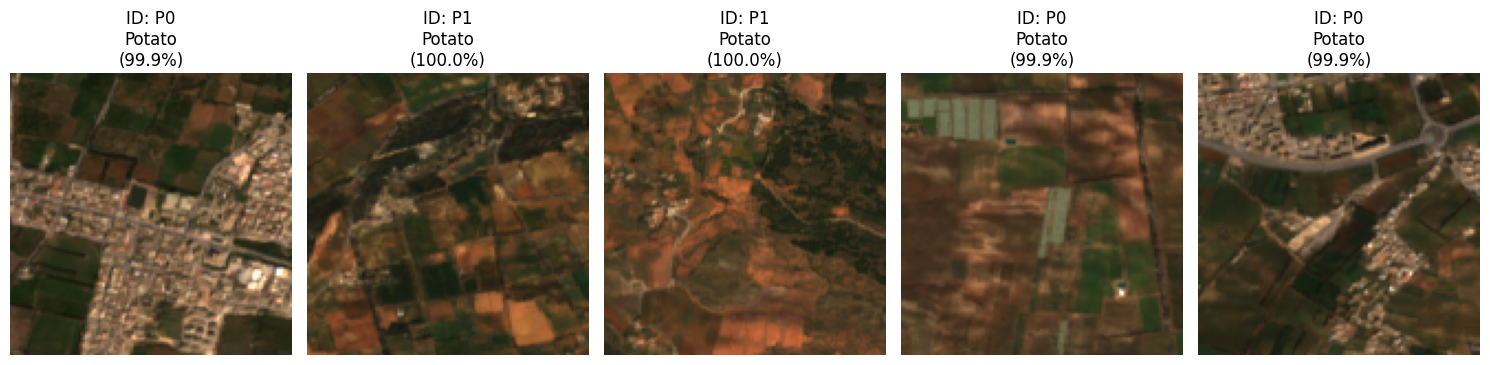

In [13]:
if len(inference_ds) > 0:
    indices = np.random.choice(len(inference_ds), min(5, len(inference_ds)), replace=False)
    
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 4))
    if len(indices) == 1: axes = [axes]
    
    for ax, idx in zip(axes, indices):
        img_tensor, patch_id = inference_ds[idx]
        
        # Get prediction
        row = df_results[df_results['id'] == patch_id].iloc[0]
        
        # Prepare image for display
        rgb = img_tensor[[2, 1, 0], :, :].permute(1, 2, 0).numpy()
        rgb = np.clip(rgb * 2.5, 0, 1)
        
        ax.imshow(rgb)
        # Title updated automatically based on df_results
        ax.set_title(f"ID: {patch_id}\n{row['class_pred']}\n({float(row['probability']):.1%})")
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

Loading data...

POTATO CLASSIFICATION RESULTS
Total Samples: 85
Accuracy:      47.06%
Precision:     50.00%
Recall:        71.11%
F1 Score:      58.72%
------------------------------


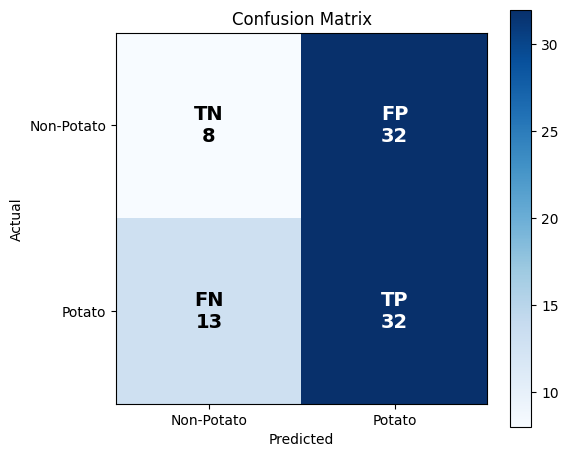

In [14]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load Data
csv_path = 'output/potato_predictions.csv'
shp_path = 'potato/Classes_PDT2021.shp' # Ensure this matches your uploaded file name

print("Loading data...")
preds_df = pd.read_csv(csv_path)
gdf = gpd.read_file(shp_path)

# 2. Map Predictions to Ground Truth
# Extract polygon index from ID (e.g., "P0_T1" -> 0)
preds_df['poly_idx'] = preds_df['id'].apply(lambda x: int(x.split('_')[0].replace('P', '')))

# Get the ground truth class column (Based on your file: 'classes')
# We map the text labels to 1 (Potato) and 0 (Non-Potato)
class_col = 'classes' 

def map_class(text):
    text = str(text).lower()
    if 'non' in text: return 0
    if 'pomme' in text: return 1
    return 0

# Link ground truth from shapefile to the predictions dataframe
gdf['binary_label'] = gdf[class_col].apply(map_class)
truth_map = gdf['binary_label'].to_dict()
preds_df['truth'] = preds_df['poly_idx'].map(truth_map)

# 3. Calculate Metrics Manually (No sklearn needed)
y_true = preds_df['truth'].values
y_pred = preds_df['raw_pred'].values

# True Positives, True Negatives, False Positives, False Negatives
TP = np.sum((y_pred == 1) & (y_true == 1))
TN = np.sum((y_pred == 0) & (y_true == 0))
FP = np.sum((y_pred == 1) & (y_true == 0))
FN = np.sum((y_pred == 0) & (y_true == 1))

total = TP + TN + FP + FN
accuracy = (TP + TN) / total
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\n" + "="*30)
print("POTATO CLASSIFICATION RESULTS")
print("="*30)
print(f"Total Samples: {total}")
print(f"Accuracy:      {accuracy:.2%}")
print(f"Precision:     {precision:.2%}")
print(f"Recall:        {recall:.2%}")
print(f"F1 Score:      {f1:.2%}")
print("-" * 30)

# 4. Plot Confusion Matrix Manually
cm = np.array([[TN, FP], [FN, TP]])
labels = [['TN', 'FP'], ['FN', 'TP']]

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap='Blues')

# Add text to the squares
for i in range(2):
    for j in range(2):
        text_color = "white" if cm[i, j] > cm.max()/2 else "black"
        text = f"{labels[i][j]}\n{cm[i, j]}"
        ax.text(j, i, text, ha="center", va="center", color=text_color, fontsize=14, fontweight='bold')

# Axis formatting
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Non-Potato', 'Potato'])
ax.set_yticklabels(['Non-Potato', 'Potato'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

# Add a colorbar
plt.colorbar(im)
plt.tight_layout()
plt.show()

In [23]:
import random
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split

# --- 1. Split Data Stratified by Class ---

# Get all generated tiles
all_files = sorted(list(OUTPUT_DIR.glob("S2_*.npy")))

# Separate by Polygon ID (Class)
# Based on your DBF file: P0 = Non-Potato, P1 = Potato
files_p0 = [f for f in all_files if '_P0_' in f.name] # Non-Potato
files_p1 = [f for f in all_files if '_P1_' in f.name] # Potato

print(f"Found {len(files_p0)} Non-Potato tiles (P0)")
print(f"Found {len(files_p1)} Potato tiles (P1)")

# Split P0 (Non-Potato) 50/50
train_p0, test_p0 = train_test_split(files_p0, test_size=0.5, random_state=42, shuffle=True)

# Split P1 (Potato) 50/50
train_p1, test_p1 = train_test_split(files_p1, test_size=0.5, random_state=42, shuffle=True)

# Combine to form final sets
train_files = train_p0 + train_p1
test_files = test_p0 + test_p1

random.shuffle(train_files)
random.shuffle(test_files)

print(f"\nFinal Split:")
print(f"  Train: {len(train_files)} tiles ({len(train_p1)} Potato, {len(train_p0)} Non-Potato)")
print(f"  Test:  {len(test_files)} tiles ({len(test_p1)} Potato, {len(test_p0)} Non-Potato)")

Found 40 Non-Potato tiles (P0)
Found 45 Potato tiles (P1)

Final Split:
  Train: 42 tiles (22 Potato, 20 Non-Potato)
  Test:  43 tiles (23 Potato, 20 Non-Potato)


In [26]:
# --- 2. Retrain Swin Model (Potato vs Non-Potato) ---

class PotatoBinaryDataset(Dataset):
    def __init__(self, file_list):
        self.files = file_list

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        try:
            # Load and normalize
            img = np.load(path).astype(np.float32)
            img = img / 10000.0
            img = np.clip(img, 0, 1)
            
            # DERIVE LABEL FROM FILENAME
            # P1 = Potato (1.0), P0 = Non-Potato (0.0)
            if '_P1_' in path.name:
                label = torch.tensor(1.0, dtype=torch.float32)
            else:
                label = torch.tensor(0.0, dtype=torch.float32)
                
            return torch.from_numpy(img), label
        except Exception as e:
            print(f"Error loading {path}: {e}")
            return torch.zeros((10, 128, 128)), torch.tensor(0.0)

# Setup Data Loader
train_ds = PotatoBinaryDataset(train_files)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)

# Initialize Model
model = create_swin_model() 
if MODEL_PATH.exists():
    state_dict = torch.load(MODEL_PATH, map_location=device, weights_only=False)
    if 'model_state_dict' in state_dict:
        model.load_state_dict(state_dict['model_state_dict'])
    else:
        model.load_state_dict(state_dict)
    print("✓ Pre-trained weights loaded.")
model.to(device)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
criterion = nn.BCEWithLogitsLoss()

# Training Loop
model.train()
EPOCHS = 20 

print(f"\nStarting retraining on {len(train_ds)} samples...")
for epoch in range(EPOCHS):
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
    avg_loss = total_loss / len(train_loader)
    acc = correct / total
    print(f"  Loss: {avg_loss:.4f} | Acc: {acc:.4f}")

print("Retraining Complete.")

✓ Pre-trained weights loaded.

Starting retraining on 42 samples...


Epoch 1/20:   0%|          | 0/3 [00:00<?, ?it/s]

  Loss: 1.9546 | Acc: 0.4762


Epoch 2/20:   0%|          | 0/3 [00:00<?, ?it/s]

  Loss: 0.9772 | Acc: 0.6905


Epoch 3/20:   0%|          | 0/3 [00:00<?, ?it/s]

  Loss: 0.5927 | Acc: 0.7857


Epoch 4/20:   0%|          | 0/3 [00:00<?, ?it/s]

  Loss: 0.6338 | Acc: 0.7619


Epoch 5/20:   0%|          | 0/3 [00:00<?, ?it/s]

  Loss: 0.4415 | Acc: 0.7143


Epoch 6/20:   0%|          | 0/3 [00:00<?, ?it/s]

  Loss: 0.4001 | Acc: 0.7619


Epoch 7/20:   0%|          | 0/3 [00:00<?, ?it/s]

  Loss: 0.3552 | Acc: 0.8810


Epoch 8/20:   0%|          | 0/3 [00:00<?, ?it/s]

  Loss: 0.3314 | Acc: 0.9048


Epoch 9/20:   0%|          | 0/3 [00:00<?, ?it/s]

  Loss: 0.2700 | Acc: 0.9048


Epoch 10/20:   0%|          | 0/3 [00:00<?, ?it/s]

  Loss: 0.2678 | Acc: 0.9286


Epoch 11/20:   0%|          | 0/3 [00:00<?, ?it/s]

  Loss: 0.2221 | Acc: 0.9524


Epoch 12/20:   0%|          | 0/3 [00:00<?, ?it/s]

  Loss: 0.1888 | Acc: 0.9762


Epoch 13/20:   0%|          | 0/3 [00:00<?, ?it/s]

  Loss: 0.1777 | Acc: 0.9286


Epoch 14/20:   0%|          | 0/3 [00:00<?, ?it/s]

  Loss: 0.1513 | Acc: 0.9762


Epoch 15/20:   0%|          | 0/3 [00:00<?, ?it/s]

  Loss: 0.1135 | Acc: 1.0000


Epoch 16/20:   0%|          | 0/3 [00:00<?, ?it/s]

  Loss: 0.1070 | Acc: 0.9762


Epoch 17/20:   0%|          | 0/3 [00:00<?, ?it/s]

  Loss: 0.0878 | Acc: 1.0000


Epoch 18/20:   0%|          | 0/3 [00:00<?, ?it/s]

  Loss: 0.1039 | Acc: 0.9286


Epoch 19/20:   0%|          | 0/3 [00:00<?, ?it/s]

  Loss: 0.0555 | Acc: 0.9762


Epoch 20/20:   0%|          | 0/3 [00:00<?, ?it/s]

  Loss: 0.0416 | Acc: 1.0000
Retraining Complete.


In [27]:
from torch.utils.data import ConcatDataset
from sklearn.metrics import classification_report, confusion_matrix

# --- 3. Combined Evaluation ---

# A. Original Crop Dataset (from inference.ipynb)
class AlgeriaCropDataset(Dataset):
    def __init__(self):
        self.data_dir = Path('/home/crop/Desktop/crop2/output/algeria_s2_data/DATA_S2')
        self.ann_dir = Path('/home/crop/Desktop/crop2/output/algeria_s2_data/ANNOTATIONS')
        self.files = sorted(self.data_dir.glob('*.npy'))
        self.valid_data = []
        for f in self.files:
            file_id = f.stem.replace('S2_', '')
            ann_path = self.ann_dir / f'Labels_{file_id}.npy'
            if ann_path.exists():
                self.valid_data.append((f, ann_path))

    def __len__(self):
        return len(self.valid_data)

    def __getitem__(self, idx):
        d_path, a_path = self.valid_data[idx]
        img = np.load(d_path)[0].astype(np.float32)
        img = img / 10000.0
        img = np.clip(img, 0, 1)
        ann = np.load(a_path)
        label = float(ann.item()) if ann.ndim == 0 else float(ann.max())
        return torch.from_numpy(img), torch.tensor(label, dtype=torch.float32)

# B. Create Test Datasets
ds_potato_test = PotatoBinaryDataset(test_files) # Contains both P0 and P1 tiles

try:
    ds_crop_test = AlgeriaCropDataset()
    print(f"Loaded {len(ds_crop_test)} external crop test samples.")
except Exception as e:
    print(f"Could not load external Crop Dataset: {e}")
    ds_crop_test = []

# C. Combine All Test Data
datasets_to_test = [ds_potato_test]
if len(ds_crop_test) > 0:
    datasets_to_test.append(ds_crop_test)

combined_test_ds = ConcatDataset(datasets_to_test)
test_loader = DataLoader(combined_test_ds, batch_size=32, shuffle=False)

# D. Evaluate
model.eval()
y_true = []
y_pred = []

print(f"\nEvaluating on {len(combined_test_ds)} combined samples...")

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluation"):
        images = images.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        
        y_true.extend(labels.numpy().astype(int))
        y_pred.extend(preds.flatten())

# E. Metrics
print("\n" + "="*60)
print("FINAL TEST RESULTS (Potato Test + External Crop Test)")
print("="*60)
print(classification_report(y_true, y_pred, target_names=['Background/Non-Potato', 'Potato/Crop']))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Loaded 193 external crop test samples.

Evaluating on 236 combined samples...


Evaluation:   0%|          | 0/8 [00:00<?, ?it/s]


FINAL TEST RESULTS (Potato Test + External Crop Test)
                       precision    recall  f1-score   support

Background/Non-Potato       0.85      0.70      0.77       133
          Potato/Crop       0.68      0.83      0.75       103

             accuracy                           0.76       236
            macro avg       0.76      0.77      0.76       236
         weighted avg       0.77      0.76      0.76       236

Confusion Matrix:
[[93 40]
 [17 86]]
